In [135]:
import pandas as pd
import json
from pandas.io.json import json_normalize    
import numpy as np
import matplotlib.pyplot as plt
import requests

#this function fetches raw detailed game event data from the NHL.  Its only input is a game ID which can be found with
#the game_code_fetcher or game_on_certain_date functions below

def NHL_live_data_fetcher(game_id):
    a = requests.get('https://statsapi.web.nhl.com/api/v1/game/{}/feed/live'.format(game_id),'records')

    data = a.json()


    b = pd.DataFrame(data['liveData']['plays']['allPlays'])
    
    return b

#this function cleans up data from the NHL_live_data_fetcher function but does not include all data entries.
#still retains most of the data

def clean_format_live_data(RAW_game_data):
    
    game_data = RAW_game_data.copy()
    
    game_data['event'] = pd.DataFrame(game_data.result.values.tolist())['event']
    game_data['description'] = pd.DataFrame(game_data.result.values.tolist())['description']

    game_data['xCoord'] = pd.DataFrame(game_data.coordinates.values.tolist())['x']
    game_data['yCoord'] = pd.DataFrame(game_data.coordinates.values.tolist())['y']

    game_data['periodType'] = pd.DataFrame(game_data.about.values.tolist())['periodType']
    game_data['period'] = pd.DataFrame(game_data.about.values.tolist())['period']
    game_data['period time'] = pd.DataFrame(game_data.about.values.tolist())['periodTime']

    temp = game_data['team'].apply(pd.Series)
    game_data['team triCode'] = temp['triCode']
    game_data['team fullName'] = temp['name']
    game_data['team id'] = temp['link']


    game_data['home goals'] = pd.DataFrame(pd.DataFrame(game_data.about.values.tolist())['goals'].tolist())['home']
    game_data['away goals'] = pd.DataFrame(pd.DataFrame(game_data.about.values.tolist())['goals'].tolist())['away']

    tempdf = game_data['players'].apply(pd.Series)

    tempdf1 = tempdf[0].apply(pd.Series)
    tempdf2 = tempdf[1].apply(pd.Series)
    tempdf3 = tempdf[2].apply(pd.Series)
    tempdf4 = tempdf[3].apply(pd.Series)

    game_data['player1 fullName'] = tempdf1['player'].apply(pd.Series)['fullName']
    game_data['player1 id'] = tempdf1['player'].apply(pd.Series)['link']
    game_data['player1 role'] = tempdf1['playerType']
    game_data['player1 seasonTotal'] = tempdf1['seasonTotal']

    game_data['player2 fullName'] = tempdf2['player'].apply(pd.Series)['fullName']
    game_data['player2 id'] = tempdf2['player'].apply(pd.Series)['link']
    game_data['player2 role'] = tempdf2['playerType']
    game_data['player2 seasonTotal'] = tempdf2['seasonTotal']

    game_data['player3 fullName'] = tempdf3['player'].apply(pd.Series)['fullName']
    game_data['player3 id'] = tempdf3['player'].apply(pd.Series)['link']
    game_data['player3 role'] = tempdf3['playerType']
    game_data['player3 seasonTotal'] = tempdf3['seasonTotal']

    game_data['player4 fullName'] = tempdf4['player'].apply(pd.Series)['fullName']
    game_data['player4 id'] = tempdf4['player'].apply(pd.Series)['link']
    game_data['player4 role'] = tempdf4['playerType']
    
    game_data.drop(['about','coordinates','players','result','team'],axis=1,inplace=True)
    
    return game_data

#this function fetches roster data for a specific game.

def NHL_game_roster_fetcher(game_id):
    a = requests.get('https://statsapi.web.nhl.com/api/v1/game/{}/feed/live'.format(game_id))

    data = a.json()


    b = pd.DataFrame(data['liveData']['boxscore']['teams']['away']['players'])
    d = b.T
    d['team'] = data['gameData']['teams']['away']['triCode']
    c = pd.DataFrame(data['liveData']['boxscore']['teams']['home']['players']) 
    e = c.T
    e['team'] = data['gameData']['teams']['home']['triCode']
    return d.append(e)

#cleans up data from the NHL_game_roster_fetcher function.

def clean_format_game_roster(raw_data):
    a = raw_data
    temp1 = a['person'].apply(pd.Series)
    temp2 = a['position'].apply(pd.Series)
    temp3 = a['stats'].apply(pd.Series)['skaterStats'].apply(pd.Series).combine_first(a['stats'].apply(pd.Series)['goalieStats'].apply(pd.Series))
    
    
    a['handedness'] = temp1['shootsCatches']
    a['fullName'] = temp1['fullName']
    a['playerLink'] = temp1['link']
    
    a['position'] = temp2['abbreviation']
    a['positionType'] = temp2['type']
    
    a=a.drop(['person','stats'],axis=1)
   
    
    return a.join(temp3)
    
    
#this function finds game ID's in a certain date range.
    
def game_code_fetcher(teamID,startdate,enddate):
    a = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId={}&startDate={}&endDate={}'.format(teamID,startdate,enddate),'records')
    
    data = a.json()
    if data['totalGames'] > 0:
        dct = {
            'dates': [],
            'gamePk': []
        }

        for i in data['dates']:
            dct['dates'].append(i['date'])
            dct['gamePk'].append(i['games'][0]['gamePk'])

        return pd.DataFrame(dct)
    else:
        return 'no games'
    

#this function finds the game ID of a game on a particular date.

def game_on_certain_date(teamID,year,month,day):
    date = '{}-{}-{}'.format(year,month,day)
    a = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId={}&startDate={}&endDate={}'.format(teamID,date,date),'records')
    data = a.json()
    
    if data['totalGames'] > 0:
        return data['dates'][0]['games'][0]['gamePk']
    else:
        return 'no games'
    

def goal_highlights(teamID,year,month,day):
    
    gamePk = game_on_certain_date(teamID,year,month,day)
    
    if gamePk != 'no games':
        
        a = requests.get('https://statsapi.web.nhl.com/api/v1/game/{}/content'.format(gamePk))
        data = a.json()

        df = pd.DataFrame(data['media']['milestones']['items'])
        df = df[df['type'] == 'GOAL']
        df['highlight'] = df['highlight'].apply(pd.Series)['playbacks']
        df['highlight'] = df['highlight'].apply(pd.Series)[9]
        df['highlight'] = df['highlight'].apply(pd.Series)['url']
        df = df.drop(['timeOffset','title','timeAbsolute','statsEventId','ordinalNum'],axis=1)
        pd.set_option('display.max_colwidth', -1)
        return df
        
    else:
        return 'no games'
    
def get_goal_links(teamID,year,month,day):
    
    return goal_highlights(teamID,year,month,day)['highlight']

def get_condensed_game(teamID,year,month,day):
    gamePk = game_on_certain_date(teamID,year,month,day)
    if gamePk != 'no games':
        
        a = requests.get('https://statsapi.web.nhl.com/api/v1/game/{}/content'.format(gamePk))
        data = a.json()
        return str(data['media']['epg'][2]['items'][0]['playbacks'][9]['url'])
    else:
        return 'no games'
        

In [136]:
get_goal_links(8,2019,10,31)

2     http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/37074ed4-d8da-46de-9c51-3febecf0615d/1572574501494/asset_1800k.mp4
3     http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/65489092-9753-4c60-9994-7a128480a7c1/1572575812123/asset_1800k.mp4
4     http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/8ccf9f4f-f1fd-4799-9b8f-cff70b780395/1572576518120/asset_1800k.mp4
7     http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/6ab09fa4-0a71-40e6-ad3e-47e8dde82f9e/1572578979454/asset_1800k.mp4
11    http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/71fb4d75-1377-49a5-97e6-6833a5b260d7/1572581385330/asset_1800k.mp4
12    http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/8ab6f727-a441-456c-a58e-1db5d2ccf74c/1572581902832/asset_1800k.mp4
13    http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/b44135cb-ea4d-493c-9423-a5ce85673601/1572582439352/asset_1800k.mp4
14    http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/b199bcd7-e8f9-40c9-b1d1-6b81e20011ac/1572583026138/asset_1800k.mp4
17    http://md-akc.med.nhl.com/mp4/nhl/2019/11/01/26f24

In [78]:
game_on_certain_date(8,2019,10,31)

2019020195

In [3]:
RAW_roster = NHL_game_roster_fetcher(2019020007)

In [4]:
roster = clean_format_game_roster(RAW_roster)

roster

,jerseyNumber,position,team,handedness,fullName,playerLink,positionType,0,assists,blocked,...,saves,shortHandedAssists,shortHandedGoals,shortHandedSavePercentage,shortHandedSaves,shortHandedShotsAgainst,shortHandedTimeOnIce,shots,takeaways,timeOnIce
ID8471743,17,C,BUF,L,Vladimir Sobotka,/api/v1/people/8471743,Forward,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,2:26,1.0,0.0,16:14
ID8473449,21,RW,BUF,R,Kyle Okposo,/api/v1/people/8473449,Forward,NaN,0.0,1.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0:00,1.0,0.0,8:40
ID8474618,6,D,BUF,L,Marco Scandella,/api/v1/people/8474618,Defenseman,NaN,0.0,3.0,...,NaN,0.0,0.0,NaN,NaN,NaN,4:37,2.0,0.0,21:33
ID8475149,90,LW,BUF,L,Marcus Johansson,/api/v1/people/8475149,Forward,NaN,0.0,1.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0:16,0.0,0.0,15:19
ID8475622,40,G,BUF,L,Carter Hutton,/api/v1/people/8475622,Goalie,NaN,0.0,NaN,...,28.0,NaN,NaN,100.0,1.0,1.0,NaN,29.0,NaN,60:00
ID8475728,22,C,BUF,L,Johan Larsson,/api/v1/people/8475728,Forward,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,5:04,2.0,0.0,14:01
ID8475784,53,LW,BUF,L,Jeff Skinner,/api/v1/people/8475784,Forward,NaN,0.0,1.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0:00,5.0,1.0,16:41
ID8476525,33,D,BUF,R,Colin Miller,/api/v1/people/8476525,Defenseman,NaN,1.0,2.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0:00,2.0,0.0,15:01
ID8476878,28,C,BUF,L,Zemgus Girgensons,/api/v1/people/8476878,Forward,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,3:36,3.0,0.0,12:56
ID8476918,13,LW,BUF,L,Jimmy Vesey,/api/v1/people/8476918,Forward,NaN,0.0,1.0,...,NaN,0.0,0.0,NaN,NaN,NaN,3:54,2.0,1.0,12:39


In [5]:
RAW_data = NHL_live_data_fetcher(2018020001)

game_data = clean_format_live_data(RAW_data)


In [10]:
game_data.loc[25:100]


,event,description,xCoord,yCoord,periodType,period,period time,team triCode,team fullName,team id,...,player2 id,player2 role,player2 seasonTotal,player3 fullName,player3 id,player3 role,player3 seasonTotal,player4 fullName,player4 id,player4 role
25,Faceoff,Par Lindholm faceoff won against Matthew Peca,-20.0,22.0,REGULAR,1,04:42,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,/api/v1/people/8476285,Loser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Hit,Par Lindholm hit Charles Hudon,-83.0,39.0,REGULAR,1,04:54,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,/api/v1/people/8476948,Hittee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Blocked Shot,Igor Ozhiganov blocked shot from Matthew Peca,73.0,-2.0,REGULAR,1,05:29,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,/api/v1/people/8476285,Shooter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Missed Shot,Kasperi Kapanen - Wide of Net,-67.0,4.0,REGULAR,1,05:37,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Missed Shot,Andreas Johnsson - Wide of Net,-75.0,-8.0,REGULAR,1,05:41,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Shot,Max Domi Snap Shot saved by Frederik Andersen,74.0,14.0,REGULAR,1,06:14,MTL,Montréal Canadiens,/api/v1/teams/8,...,/api/v1/people/8475883,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Stoppage,Goalie Stopped,NaN,NaN,REGULAR,1,06:15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Faceoff,Auston Matthews faceoff won against Max Domi,69.0,22.0,REGULAR,1,06:15,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,/api/v1/people/8477503,Loser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,Giveaway,Giveaway by Jake Gardiner,64.0,-40.0,REGULAR,1,06:25,TOR,Toronto Maple Leafs,/api/v1/teams/10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,Takeaway,Takeaway by Phillip Danault,-61.0,3.0,REGULAR,1,07:20,MTL,Montréal Canadiens,/api/v1/teams/8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [612]:
shots_only = game_data[game_data['event'] == 'Shot']
goals_only = game_data[game_data['event'] == 'Goal']

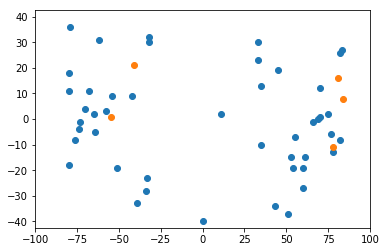

In [613]:
fig = plt.figure()

xaxis = shots_only['xCoord']
yaxis = shots_only['yCoord']

xaxis2 = goals_only['xCoord']
yaxis2 = goals_only['yCoord']

plt.ylim(-42.5,42.5)
plt.xlim(-100,100)
plt.scatter(xaxis,yaxis)
plt.scatter(xaxis2,yaxis2)

In [332]:
shots_only

,event,description,xCoord,yCoord,periodType,period,period time,team triCode,team fullName,team id,...,player2 id,player2 role,player2 seasonTotal,player3 fullName,player3 id,player3 role,player3 seasonTotal,player4 fullName,player4 id,player4 role
8,Shot,Shayne Gostisbehere Snap Shot saved by Andrei Vasilevskiy,-50.0,31.0,REGULAR,1,00:42,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Shot,Travis Konecny Wrist Shot saved by Andrei Vasilevskiy,-60.0,29.0,REGULAR,1,04:01,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Shot,Claude Giroux Wrist Shot saved by Andrei Vasilevskiy,-41.0,-20.0,REGULAR,1,06:57,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,Shot,Mikhail Sergachev Wrist Shot saved by Petr Mrazek,6.0,33.0,REGULAR,1,07:35,TBL,Tampa Bay Lightning,14.0,...,8475852.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,Shot,Adam Erne Backhand saved by Petr Mrazek,77.0,-12.0,REGULAR,1,11:26,TBL,Tampa Bay Lightning,14.0,...,8475852.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,Shot,Taylor Leier Snap Shot saved by Andrei Vasilevskiy,-37.0,-25.0,REGULAR,1,12:21,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Shot,J.T. Miller Wrist Shot saved by Petr Mrazek,83.0,21.0,REGULAR,1,13:13,TBL,Tampa Bay Lightning,14.0,...,8475852.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,Shot,Steven Stamkos Wrist Shot saved by Petr Mrazek,81.0,8.0,REGULAR,1,13:15,TBL,Tampa Bay Lightning,14.0,...,8475852.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Shot,Jakub Voracek Wrist Shot saved by Andrei Vasilevskiy,-73.0,2.0,REGULAR,1,14:28,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,Shot,Ivan Provorov Wrist Shot saved by Andrei Vasilevskiy,-50.0,-14.0,REGULAR,1,15:55,PHI,Philadelphia Flyers,4.0,...,8476883.0,Goalie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
RAW_data


,about,coordinates,players,result,team
0,"{u'eventId': 1, u'periodTime': u'00:00', u'eve...",{},NaN,"{u'eventTypeId': u'GAME_SCHEDULED', u'event': ...",NaN
1,"{u'eventId': 5, u'periodTime': u'00:00', u'eve...",{},NaN,"{u'eventTypeId': u'PERIOD_READY', u'event': u'...",NaN
2,"{u'eventId': 8, u'periodTime': u'00:00', u'eve...",{},NaN,"{u'eventTypeId': u'PERIOD_START', u'event': u'...",NaN
3,"{u'eventId': 9, u'periodTime': u'00:00', u'eve...","{u'y': 0.0, u'x': 0.0}","[{u'player': {u'fullName': u'Max Domi', u'link...","{u'eventTypeId': u'FACEOFF', u'event': u'Faceo...","{u'triCode': u'MTL', u'link': u'/api/v1/teams/..."
4,"{u'eventId': 10, u'periodTime': u'00:29', u'ev...","{u'y': -19.0, u'x': 78.0}",[{u'player': {u'fullName': u'Artturi Lehkonen'...,"{u'secondaryType': u'Backhand', u'eventTypeId'...","{u'triCode': u'MTL', u'link': u'/api/v1/teams/..."
5,"{u'eventId': 11, u'periodTime': u'00:49', u'ev...","{u'y': -10.0, u'x': -37.0}","[{u'player': {u'fullName': u'Morgan Rielly', u...","{u'secondaryType': u'Snap Shot', u'eventTypeId...","{u'triCode': u'TOR', u'link': u'/api/v1/teams/..."
6,"{u'eventId': 12, u'periodTime': u'01:00', u'ev...","{u'y': -23.0, u'x': 47.0}",[{u'player': {u'fullName': u'Brendan Gallagher...,"{u'secondaryType': u'Wrist Shot', u'eventTypeI...","{u'triCode': u'MTL', u'link': u'/api/v1/teams/..."
7,"{u'eventId': 151, u'periodTime': u'01:01', u'e...",{},NaN,"{u'eventTypeId': u'STOP', u'event': u'Stoppage...",NaN
8,"{u'eventId': 13, u'periodTime': u'01:01', u'ev...","{u'y': -22.0, u'x': 69.0}","[{u'player': {u'fullName': u'Nazem Kadri', u'l...","{u'eventTypeId': u'FACEOFF', u'event': u'Faceo...","{u'triCode': u'TOR', u'link': u'/api/v1/teams/..."
9,"{u'eventId': 14, u'periodTime': u'02:00', u'ev...","{u'y': 15.0, u'x': 56.0}","[{u'player': {u'fullName': u'John Tavares', u'...","{u'eventTypeId': u'BLOCKED_SHOT', u'event': u'...","{u'triCode': u'TOR', u'link': u'/api/v1/teams/..."


In [39]:
def game_code_fetcher(teamID,startdate,enddate):
    a = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId={}&startDate={}&endDate={}'.format(teamID,startdate,enddate),'records')
    
    data = a.json()
    if data['totalGames'] > 0:
        dct = {
            'dates': [],
            'gamePk': []
        }

        for i in data['dates']:
            dct['dates'].append(i['date'])
            dct['gamePk'].append(i['games'][0]['gamePk'])

        return pd.DataFrame(dct)
    else:
        return 'no games'